In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN

In [2]:
path = "../data/clean"
patient_df = pd.read_pickle(f"{path}/patient_level_features_med_num.pkl")
df = pd.read_pickle(f"{path}/feature_ls.pkl")
X_pca = np.load(f"{path}/X_pca.npy")
#labels = np.load(f"{path}/labels.npy")
df_unsup = pd.read_pickle(f"{path}/df_unsupervised_final.pkl")

In [3]:
# readin hcpcs mapper
mapper_path = "../data/mappers"
hcpcs_mapper = pd.read_pickle(f"{mapper_path}/hcpcs.pkl")
drg_mapper = pd.read_pickle(f"{mapper_path}/drg.pkl")
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

In [4]:
drg_mapper.head()

,DRG,MDC,DRG_description,MDC_description
0,001,NaN,Heart transplant or implant of heart assist sy...,NaN
1,002,NaN,Heart transplant or implant of heart assist sy...,NaN
2,003,NaN,ECMO o r tracheostomy with MV >96 hours or PDX...,NaN
3,004,NaN,Trache ostomy with MV >96 hours or PDX except ...,NaN
4,005,NaN,Liver transplant with MCC or intestinal transp...,NaN


In [25]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
    elif model_type == 'dbscan':
        centers = []
        for label in unique_labels:
            if label == -1:
                continue  # skip noise
            cluster_points = X_pca[labels == label]
            centers.append(list(cluster_points.mean(axis=0)))
            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % (i + 1), 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [33]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
    elif model_type == 'dbscan':
        centers = []
        for label in unique_labels:
            if label == -1:
                continue  # skip noise
            cluster_points = X_pca[labels == label]
            centers.append(list(cluster_points.mean(axis=0)))
            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % (i + 1), 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [14]:
df_desc = pd.merge(df, hcpcs_mapper, how = 'left', left_on = 'feature', right_on = 'Code')

In [15]:
df_desc

,component,feature,Code,Description
0,PC1,HCPCS_level_1,NaN,NaN
1,PC2,S9126,S9126,"Hospice care, in the home, per diem"
2,PC3,G8946,G8946,Minimally invasive biopsy method attempted but...
3,PC4,H2000,H2000,Comprehensive multidisciplinary evaluation
4,PC5,G0444,G0444,"Annual depression screening, 5 to 15 minutes"
5,PC6,T1502,T1502,"Administration of oral, intramuscular and/or s..."
6,PC7,S9473,S9473,"Pulmonary rehabilitation program, non-physicia..."
7,PC8,S0605,NaN,NaN
8,PC9,G0102,G0102,Prostate cancer screening; digital rectal exam...
9,PC10,C8928,C8928,"Transthoracic echocardiography with contrast, ..."


In [21]:
kmeans = KMeans(init = 'k-means++', n_clusters=8, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

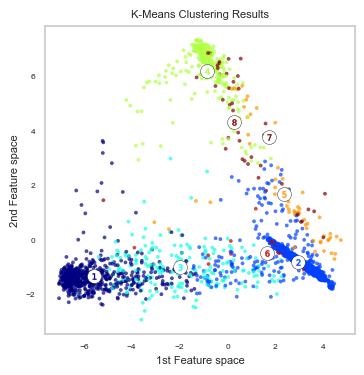

In [471]:
# fig, ax = plt.subplots(figsize=(4, 4))
# create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

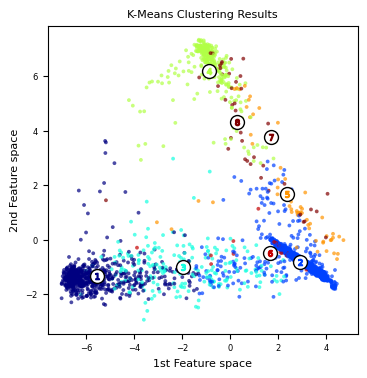

In [34]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

Look at patients with the most relevant PCA features in combined_hcpcs_ls

In [36]:
ls = [x for x in df_desc['feature']][1:]
ls

['S9126',
 'G8946',
 'H2000',
 'G0444',
 'T1502',
 'S9473',
 'S0605',
 'G0102',
 'C8928',
 'G9708']

In [37]:
df_unsup['cluster'].value_counts()

cluster
1    1337
0     626
3     300
2     206
4      63
7      36
5      28
6      11
Name: count, dtype: int64

In [38]:
# merge on cluster
df_eval = pd.concat([patient_df, df_unsup], axis = 1)

In [39]:
mask = df_eval['combined_hcpcs_ls'].apply(lambda x:list( set([1 for code in x if code in ls]))).apply(lambda x: 1 if len(x) > 0 else 0)

In [40]:
mask.unique()

array([1, 0])

In [41]:
# limit to rows that have hcpcs code in it
df_eval = df_eval[ mask == 1]

In [42]:
df_eval['cluster'].value_counts()

cluster
1    1304
0     612
3     300
2     206
4      63
7      36
5      28
6      11
Name: count, dtype: int64

In [43]:
df_eval.head()

,patient_medicare_number,gender,age,number_of_claims,preventative_care_ind,combined_hcpcs_ls,combined_diagnosis_ls,combined_principal_diagnosis_ls,drg_ls,total_value,...,HCPCS_level_2,HCPCS_level_1,Outpatient_PPS,National_Codes_Established_for_State_Medicaid_Agencies,Temporary_National_Codes_(Non-Medicare),Temporary_Codes,Alcohol_and_Drug_Abuse_Treatment,Evaluation_and_Management_(E/M)_Codes_,Procedures/Professional_Services,cluster
0,1S00E00AA10,0,79.0,18,1,"[G0444, 99221, G0444, G0444, G0444, 99221, 992...","[O039, O039, S63509, O039, O039, O039, O039, S...","[O039, O039, B002, B002, B085, O039, S8290X, J...","[001, 001, 001]",149.37,...,0.746346,0.665558,0.0,0.0,0.0,0.0,0.0,0.665558,0.746346,1
1,1S00E00AA16,1,75.0,17,1,"[99241, G0444, 99241, G0444, 99241, G0444, G95...","[E669, E785, E669, E785, E669, E785, E669, E78...","[E785, E785, E785, E785, B085, E785, E785, J01...",[],234.72,...,0.450512,0.892770,0.0,0.0,0.0,0.0,0.0,0.892770,0.450512,1
2,1S00E00AA23,0,77.0,29,1,"[99241, 99241, 99241, G0444, 99241, 99241, 992...","[J329, E785, I10, J329, E785, P292, J329, E785...","[J329, E785, J329, J029, J329, J029, J329, J32...",[],85.55,...,0.344529,0.938776,0.0,0.0,0.0,0.0,0.0,0.938776,0.344529,1
3,1S00E00AA25,0,78.0,24,1,"[G0107, G0444, 99241, G0444, G0444, 99241, G04...","[E669, D649, K635, O039, M810, J329, Z3400, E6...","[Z3400, Z3400, Z3400, J0190, E669, S72009, J01...",[001],21901.40,...,0.517980,0.855392,0.0,0.0,0.0,0.0,0.0,0.855392,0.517980,1
4,1S00E00AA32,1,80.0,19,1,"[G0444, 99241, G0444, G0444, G0444, G9572, 992...","[P292, E669, I2510, P292, J209, E669, I2510, I...","[J209, J209, J329, J0390, I10, J209, J209, J20...",[001],8388.69,...,0.949550,0.313617,0.0,0.0,0.0,0.0,0.0,0.313617,0.949550,1


In [44]:
# create principal diagnosis list by cluster
grp = df_eval.groupby('cluster')['combined_principal_diagnosis_ls'].apply(list)
grp_df_principal = pd.DataFrame(grp)
grp_df_principal.reset_index(inplace=True)
grp_df_principal

,cluster,combined_principal_diagnosis_ls
0,0,"[[E785, N390, E785, E785, E785, E785, E785, E7..."
1,1,"[[O039, O039, B002, B002, B085, O039, S8290X, ..."
2,2,"[[M810, M810, M810, M810, M810, M810, M810, M8..."
3,3,"[[J209, S93409, J0190, J0190, F0280, B9789, B9..."
4,4,"[[C50929, C50919, J45909, J45909, C50929, C509..."
5,5,"[[Z3480, Z3480, J0190, J0190, J0190, J0190, J0..."
6,6,"[[I639, B002, B002, J0190, B9789, B9789, B9789..."
7,7,"[[M179, H6690, J329, J329, J329, J329, J329, J..."


In [45]:
# create unique principal diagnosis list by cluster
grp_df_principal['unique_prinicpal_ls'] = grp_df_principal['combined_principal_diagnosis_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [47]:
# look at lengths of unqiue principal diagnosis list
grp_df_principal['principal_drg_ls_len'] = grp_df_principal['unique_prinicpal_ls'].str.len()
vals = grp_df_principal['principal_drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
principal_drg_ls_len,
138,1
144,1
109,1
122,1
63,1
41,1
26,1
46,1


In [54]:
grp_df_principal.head()

,cluster,combined_principal_diagnosis_ls,unique_prinicpal_ls,principal_drg_ls_len
0,0,"[[E785, N390, E785, E785, E785, E785, E785, E7...","[S83519, R0902, S51819, J0380, G300, M8000X, J...",138
1,1,"[[O039, O039, B002, B002, B085, O039, S8290X, ...","[G53, S51819, E1144, J0380, G300, M8000X, J128...",144
2,2,"[[M810, M810, M810, M810, M810, M810, M810, M8...","[G53, E1144, S51819, J0380, J1289, S63003, M19...",109
3,3,"[[J209, S93409, J0190, J0190, F0280, B9789, B9...","[G53, S51819, E1144, J0380, G300, M8000X, J128...",122
4,4,"[[C50929, C50919, J45909, J45909, C50929, C509...","[M797, M109, E669, P2981, M179, S93409, E034, ...",63


In [48]:
# create principal diagnosis list by cluster
grp = df_eval.groupby('cluster')['drg_ls'].apply(list)
grp_df = pd.DataFrame(grp)
grp_df.reset_index(inplace=True)
grp_df

,cluster,drg_ls
0,0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9..."
1,1,"[[001, 001, 001], [], [], [001], [001], [], [0..."
2,2,"[[975], [], [922, 923, 012, 159, 923, 950, 949..."
3,3,"[[001], [003, 003, 003, 003, 003, 003, 003, 00..."
4,4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,..."
5,5,"[[001], [964, 444], [976], [446], [204, 203, 9..."
6,6,"[[066, 582, 598], [152, 599, 597, 597, 583, 58..."
7,7,"[[001, 003, 001, 001], [003], [], [001], [], [..."


In [49]:
# create unique drg list by cluster
grp_df['unique_drg_ls'] = grp_df['drg_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [52]:
# look at length of drg list
grp_df['unique_drg_ls_len'] = grp_df['unique_drg_ls'].str.len()
vals = grp_df['unique_drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
unique_drg_ls_len,
123,1
133,1
60,1
107,1
64,1
29,1
16,1
37,1


In [53]:
grp_df.head(10)

,cluster,drg_ls,unique_drg_ls,unique_drg_ls_len
0,0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9...","[308, 013, 963, 559, 090, 124, 770, 949, 555, ...",123
1,1,"[[001, 001, 001], [], [], [001], [001], [], [0...","[308, 013, 963, 559, 090, 690, 023, 124, 770, ...",133
2,2,"[[975], [], [922, 923, 012, 159, 923, 950, 949...","[918, 553, 963, 793, 008, 304, 794, 395, 641, ...",60
3,3,"[[001], [003, 003, 003, 003, 003, 003, 003, 00...","[308, 013, 963, 559, 770, 949, 555, 557, 560, ...",107
4,4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,...","[185, 583, 918, 013, 974, 061, 553, 963, 793, ...",64
5,5,"[[001], [964, 444], [976], [446], [204, 203, 9...","[974, 204, 195, 637, 976, 179, 812, 202, 779, ...",29
6,6,"[[066, 582, 598], [152, 599, 597, 597, 583, 58...","[583, 561, 597, 812, 950, 152, 394, 770, 779, ...",16
7,7,"[[001, 003, 001, 001], [003], [], [001], [], [...","[191, 013, 918, 963, 793, 008, 641, 791, 158, ...",37


In [55]:
grp_df_cloud = grp_df.copy()

In [56]:
# create work cloud column of diagnosis descriptions

for index, row in grp_df_cloud.iterrows():
    print(index)
    #print(row['principal_unq'])
    if len(row['unique_drg_ls']) > 1:
        row_ls = []
        for code in row['unique_drg_ls']:
            #print(code)
            if drg_mapper['DRG'].isin([code]).any():
                ind = drg_mapper[drg_mapper['DRG'].str.contains(code)].index[0].item()
                #print(ind)
                text = drg_mapper.loc[ind, 'MDC_description']
                #print(f"text {text}")
                if type(text) == str:
                    text = text.replace('DISEASES & DISORDERS OF ', '')
                    text = text.replace('DISEASES', '')
                    text = text.replace('DISORDERS', '')
                    text = text.replace('THE ', '')
                    text = text.replace('SYSTEM', '')
                    text = text.replace("'", '')
                    #print(text)
                    #continue
                if type(text) == float:
                    continue
                    #print(f"text nan {text}") 

                row_ls = row_ls + [text]
        print(row_ls)
        grp_df_cloud.at[index, 'word_cloud'] = str(set(row_ls))

    # else:
    #     #print(code)
    #     if icd10_mapper['CODE'].str.contains(code).any():
    #         ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
    #         #print(ind)
    #         text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
    #         text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
    #         print(f"text {text}")
    #         df_unsupervised.at[index, 'word_cloud'] = str(set(text))

0
['CIRCULATORY ', 'MULTIPLE SIGNIFICANT TRAUMA', 'MUSCULOSKELETAL  & CONN TISSUE', 'NERVOUS ', 'EYE', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'MUSCULOSKELETAL  & CONN TISSUE', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'MUSCULOSKELETAL  & CONN TISSUE', 'MUSCULOSKELETAL  & CONN TISSUE', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'DIGESTIVE ', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'MUSCULOSKELETAL  & CONN TISSUE', 'HEPATOBILIARY  & PANCREAS', 'EYE', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'RESPIRATORY ', 'NERVOUS ', 'DIGESTIVE ', 'DIGESTIVE ', 'CIRCULATORY ', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'MUSCULOSKELETAL  & CONN TISSUE', 'NERVOUS ', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'DIGESTIVE ', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'INJURIES, POISONINGS & T

In [57]:
for cloud in grp_df_cloud['word_cloud']:
    print(len(cloud.split(',')))

29
28
25
28
25
21
16
21


In [58]:
for group in grp_df_cloud['word_cloud']:
    print(group)

{'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'MULTIPLE SIGNIFICANT TRAUMA', 'MENTAL  & ', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'EAR, NOSE, MOUTH & THROAT', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'NERVOUS ', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'KIDNEY & URINARY TRACT', 'HEPATOBILIARY  & PANCREAS', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'CIRCULATORY ', 'EYE', 'HUMAN IMMUNODEFICIENCY VIRUS INFECTIONS', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'DIGESTIVE '}
{'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'MULTIPLE SIGNIFICANT TRAUMA', 'MENTAL  & ', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'EAR, NOSE, MOUTH & THROAT', 'MUSCU

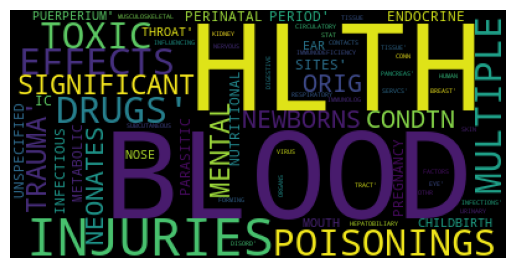

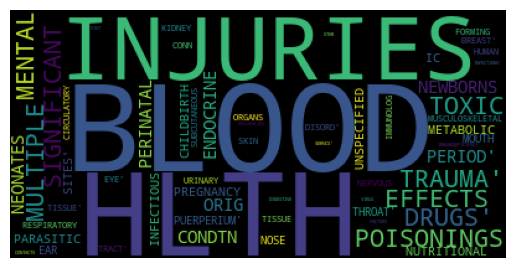

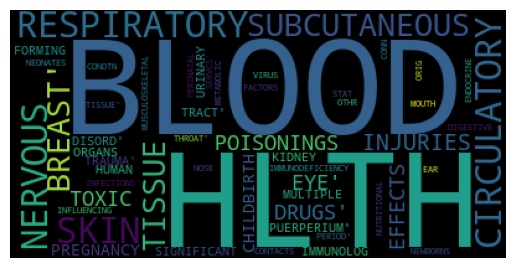

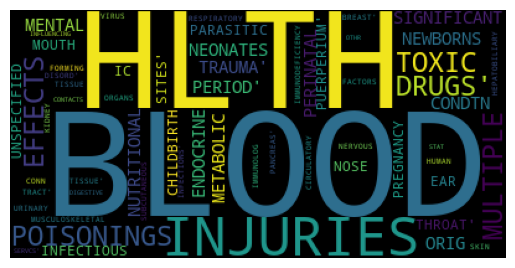

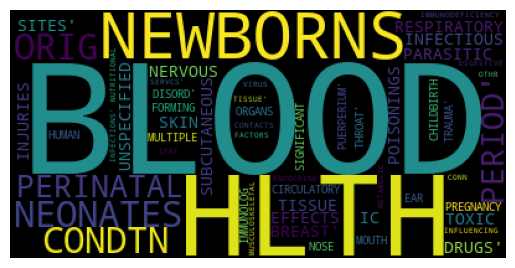

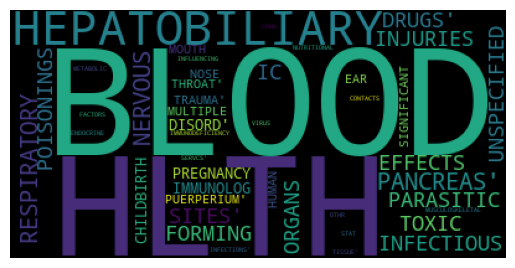

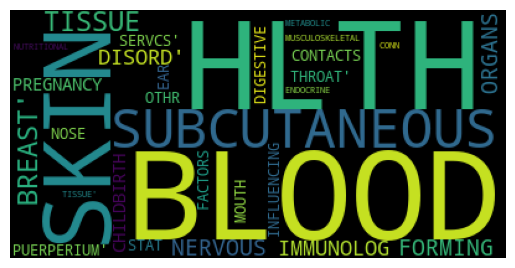

In [59]:
n_clusters = 7
for cluster in range(0,n_clusters):
    df_cluster = grp_df_cloud[grp_df_cloud['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Use matplotlib.pyplot to display the fitted wordcloud
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [74]:
# create work cloud column of diagnosis descriptions

for index, row in grp_df_principal.iterrows():
    print(index)
    #print(row['principal_unq'])
    if len(row['unique_prinicpal_ls']) > 1:
        row_ls = []
        for code in row['unique_prinicpal_ls']:
            #print(code)
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                #print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split(' ')[0:4]
                print(f"text {text}") 
            #row_ls.append(text)
            print(text)
            #row_ls = row_ls.append(text)
            row_ls = row_ls + text
        #print(row_ls)
        #row_ls = [ word for word in row_ls if word != ',']
        #row_ls = [ word.strip(", '") for word in row_ls if word.strip(", '") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        row_ls = [ word for word in row_ls if word.strip(",'") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        #print(row_ls)
        grp_df_principal.at[index, 'word_cloud'] = str(set(row_ls))
        # df_unsupervised.at[index, 'word_cloud']= pd.Series([row_ls] * len(df_unsupervised))
        # df_unsupervised.assign(word_cloud =  [row_ls for i in df_unsupervised.index])

    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
            #print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
            #text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
            text = [ word for word in text if word.strip(",'") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        
            print(f"text {text}")
            grp_df_principal.at[index, 'word_cloud'] = str(set(text))

0
['Emphysema,', 'unspecified']
text ['Hypoxemia']
['Hypoxemia']
['Hypoxemia']
text ['Acute', 'tonsillitis', 'due', 'to']
['Acute', 'tonsillitis', 'due', 'to']
text ["Alzheimer's", 'disease', 'with', 'early']
["Alzheimer's", 'disease', 'with', 'early']
["Alzheimer's", 'disease', 'with', 'early']
text ['Other', 'viral', 'pneumonia']
['Other', 'viral', 'pneumonia']
text ['Neonatal', 'urinary', 'tract', 'infection']
['Neonatal', 'urinary', 'tract', 'infection']
['Neonatal', 'urinary', 'tract', 'infection']
['Neonatal', 'urinary', 'tract', 'infection']
text ['Type', '2', 'diab', 'with']
['Type', '2', 'diab', 'with']
text ['Primary', 'osteoarthritis,', 'unspecified', 'hand']
['Primary', 'osteoarthritis,', 'unspecified', 'hand']
text ['Spontaneous', 'rupture', 'of', 'other']
['Spontaneous', 'rupture', 'of', 'other']
text ['Unspecified', 'acute', 'lower', 'respiratory']
['Unspecified', 'acute', 'lower', 'respiratory']
text ['Bacterial', 'sepsis', 'of', 'newborn,']
['Bacterial', 'sepsis', 'of'

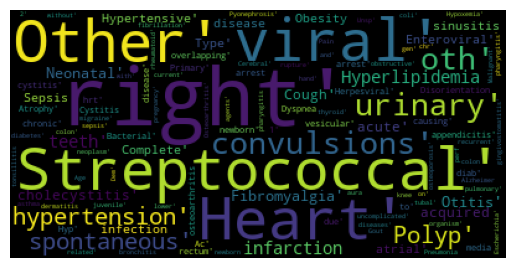

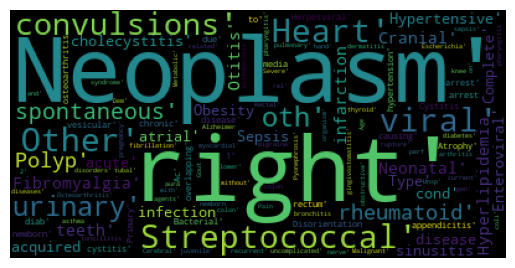

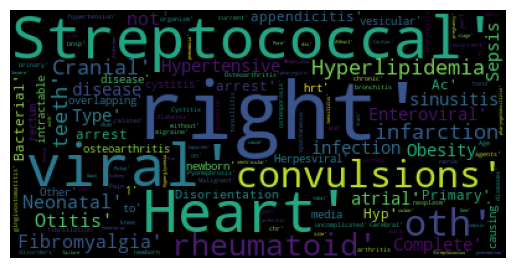

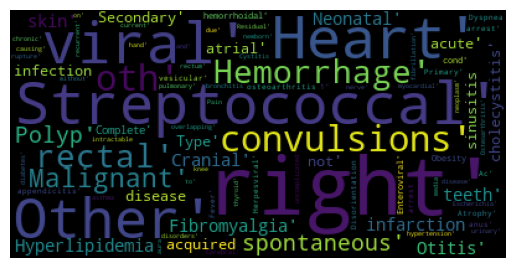

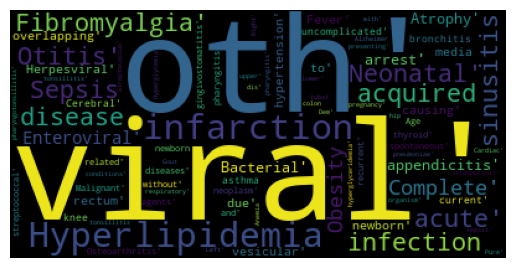

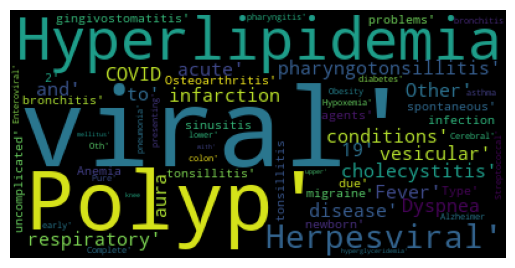

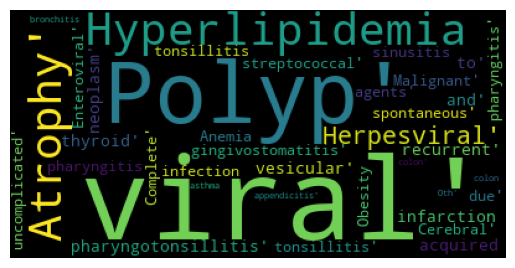

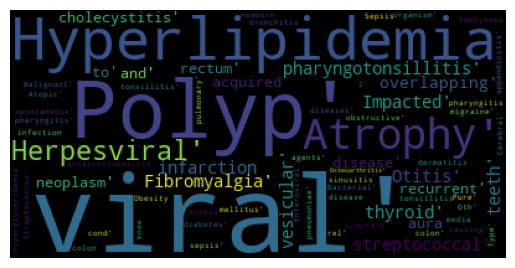

In [78]:
n_clusters = 8
for cluster in range(0,n_clusters):
    df_cluster =grp_df_principal[grp_df_principal['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    diag_cloud = diag_cloud.strip(" '")
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Use matplotlib.pyplot to display the fitted wordcloud
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()